In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import torch

# PLM Stability Functions

In [29]:
from transformers import AutoTokenizer, EsmForMaskedLM
import torch
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

RuntimeError: Failed to import transformers.models.esm.modeling_esm because of the following error (look up to see its traceback):
partially initialized module 'torch._inductor' from '/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/torch/_inductor/__init__.py' has no attribute 'custom_graph_pass' (most likely due to a circular import)

In [11]:
AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")


In [5]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")

TOKENIZER = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
MODEL = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t33_650M_UR50D")

KeyboardInterrupt: 

In [6]:
!pip install --upgrade ipywidgets
!pip install widgetsnbextension pandas-profiling
!jupyter nbextension enable --py widgetsnbextension


  Using cached pandas_profiling-3.2.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached pydantic-2.11.1-py3-none-any.whl.metadata (63 kB)
  Using cached MarkupSafe-2.1.5.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached visions-0.7.4-py3-none-any.whl.metadata (5.9 kB)
  Using cached htmlmin-0.1.12.tar.gz (19 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
          exec(compile('''
          ~~~~^^^^^^^^^^^^
          # This is <pip-setuptools-caller> -- a caller that pip uses to run setup.py
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
          ...<31 lines>...
          exec(compile(setup_py_code, filename, "exec"))
          ^^^^^^^

In [17]:
from tqdm.notebook import tqdm
import numpy as np

def generate_mutation_heatmap(sequence, start_pos=1, end_pos=None, save=False):
    input_ids = TOKENIZER.encode(sequence, return_tensors="pt")
    sequence_length = input_ids.shape[1] - 2

    if end_pos == None:
        end_pos = sequence_length

    heatmap = np.zeros((20, end_pos - start_pos + 1))

    for position in tqdm(range(start_pos, end_pos + 1), desc="Calculating Position PLL"):
        # mask target position
        masked_input_ids = input_ids.clone()
        masked_input_ids[0, position] = TOKENIZER.mask_token_id

        # get logits for when the target position is masked
        with torch.no_grad():
            logits = MODEL(masked_input_ids).logits

        # calc log probs
        probabilities = torch.nn.functional.softmax(logits[0, position], dim=0)
        log_probabilities = torch.log(probabilities)

        # get log prob of wild type residue
        wt_residue = input_ids[0, position].item()
        log_prob_wt = log_probabilities[wt_residue].item()

        for i, amino_acid in enumerate(AMINO_ACIDS):
            # get mutated log probability
            log_prob_mt = log_probabilities[TOKENIZER.convert_tokens_to_ids(amino_acid)].item()
            heatmap[i, position - start_pos] = log_prob_mt - log_prob_wt

        if save:
            np.save("sequence_mutation_heatmap.npy", heatmap)

    
    return heatmap

In [16]:
import matplotlib.pyplot as plt
def visualize_heatmap(heatmap, protein_sequence, start_pos, end_pos):
    # Visualize the heatmap
    plt.figure(figsize=(15, 5))
    print(heatmap.shape)
    plt.imshow(heatmap[:, start_pos - 1:end_pos], cmap="viridis", aspect="auto")
    plt.xticks(range(end_pos - start_pos + 1), list(protein_sequence[start_pos-1:end_pos]))
    plt.yticks(range(20), AMINO_ACIDS)
    plt.xlabel("Position in Protein Sequence")
    plt.ylabel("Amino Acid Mutations")
    plt.title("Predicted Effects of Mutations on Protein Sequence (LLR)")
    plt.colorbar(label="Log Likelihood Ratio (LLR)")
    plt.show()

# Running on Original Sequence


In [12]:
# get the sequence
seq = open('../sequence.fasta', 'r').read()
seq = seq.split("\n")[1]
print(seq)

MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP


In [13]:
heatmap = generate_mutation_heatmap(seq, start_pos=1, end_pos=None, save=True)
np.save("sequence_mutation_heatmap.npy", heatmap)

Calculating Position PLL:   0%|          | 0/656 [00:00<?, ?it/s]

(20, 656)


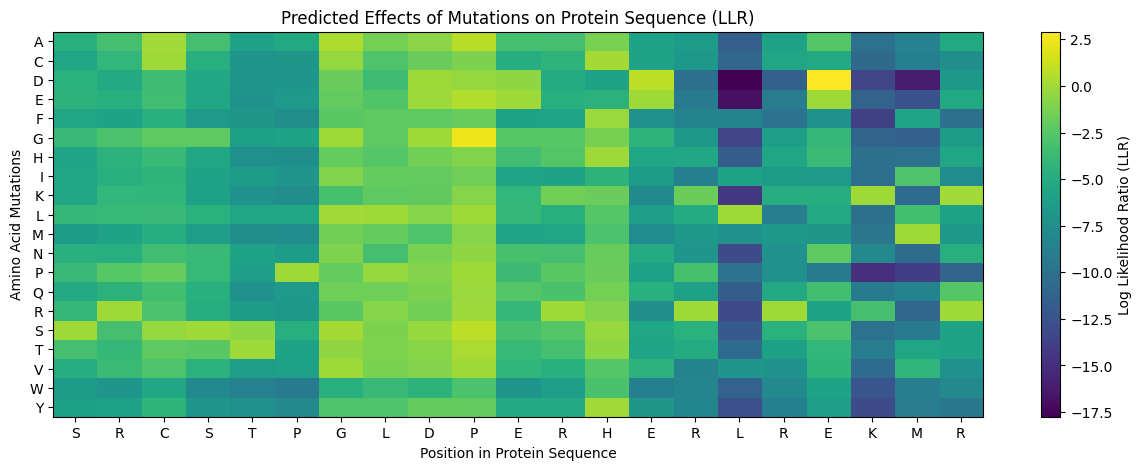

In [18]:
visualize_heatmap(heatmap, protein_sequence=seq, start_pos=30, end_pos=50)

# Integrate with Test Data

Generate `plm_test_embedding.parquet`

In [31]:
heatmap = np.load("sequence_mutation_heatmap.npy")

In [32]:
df_unlabeled = pd.read_csv("../test.csv")
df_unlabeled.head()

,mutant
0,V1D
1,V1Y
2,V1C
3,V1A
4,V1E


In [36]:
def lookup_mutation(mutation_str):
    new_aa = mutation_str[-1]
    position = int(mutation_str[1:-1])

    new_aa_index = AMINO_ACIDS.index(new_aa)

    return heatmap[new_aa_index, position]

In [37]:
print(heatmap.shape)

(20, 656)


In [38]:
df_unlabeled["plm_stability"] = df_unlabeled["mutant"].apply(lambda x: lookup_mutation(x))
df_unlabeled.head()

,mutant,plm_stability
0,V1D,0.352811
1,V1Y,-0.886620
2,V1C,-0.604995
3,V1A,1.840761
4,V1E,1.392013


In [39]:
df_unlabeled.to_parquet("plm_test_embedding.parquet")

In [43]:
df_sorted = df_unlabeled.sort_values(by="plm_stability")
df_sorted.tail()

,mutant,plm_stability
7160,L436K,6.015554
7157,L436R,6.082617
5165,M326V,6.235556
2398,R133S,6.351557
10131,R593Q,7.807389


## Check againnst top10 submissions

In [44]:
submission_1 = np.array([
    "Q266K",
    "G186I",
    "N648L",
    "N486I",
    "G6I",
    "N546I",
    "N546L",
    "N546W",
    "N486W",
    "N486L"
])

submission_2 = np.array([
    "N546W",
    "D622W",
    "A654W",
    "D637W",
    "D613W",
    "A649W",
    "D628W",
    "S604W",
    "S602W",
    "G595W"
])

In [48]:
df_unlabeled_1 = df_unlabeled[df_unlabeled.mutant.isin(submission_1)]
df_unlabeled_2 = df_unlabeled[df_unlabeled.mutant.isin(submission_2)]

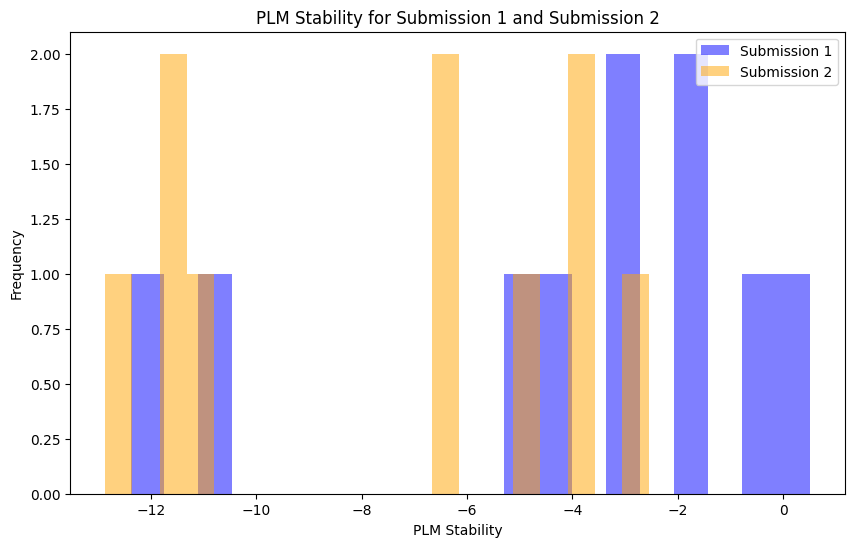

In [49]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))

# Plot for df_unlabeled_1 (submission_1)
plt.hist(df_unlabeled_1['plm_stability'], bins=20, alpha=0.5, label='Submission 1', color='blue')

# Plot for df_unlabeled_2 (submission_2)
plt.hist(df_unlabeled_2['plm_stability'], bins=20, alpha=0.5, label='Submission 2', color='orange')

# Add labels and title
plt.xlabel('PLM Stability')
plt.ylabel('Frequency')
plt.title('PLM Stability for Submission 1 and Submission 2')

# Show legend
plt.legend()

# Display the plot
plt.show()

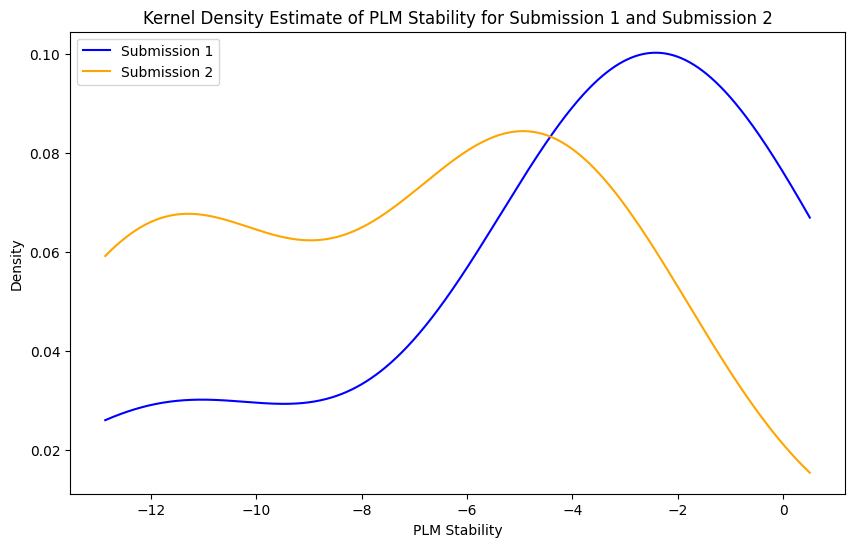

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Create KDEs for each submission
kde_1 = gaussian_kde(df_unlabeled_1['plm_stability'])
kde_2 = gaussian_kde(df_unlabeled_2['plm_stability'])

# Create an array of x values for the plot
x_vals = np.linspace(min(df_unlabeled_1['plm_stability'].min(), df_unlabeled_2['plm_stability'].min()), 
                     max(df_unlabeled_1['plm_stability'].max(), df_unlabeled_2['plm_stability'].max()), 
                     1000)

# Plot the KDEs
plt.figure(figsize=(10, 6))
plt.plot(x_vals, kde_1(x_vals), label='Submission 1', color='blue')
plt.plot(x_vals, kde_2(x_vals), label='Submission 2', color='orange')

# Add labels and title
plt.xlabel('PLM Stability')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of PLM Stability for Submission 1 and Submission 2')

# Show legend
plt.legend()

# Display the plot
plt.show()


# Spearman on Training

In [2]:
import pandas as pd

import numpy as np

df_train_labeled = pd.read_csv("../train.csv")

heatmap = np.load("sequence_mutation_heatmap.npy")

In [3]:

def lookup_mutation(mutation_str):
    new_aa = mutation_str[-1]
    position = int(mutation_str[1:-1])

    new_aa_index = AMINO_ACIDS.index(new_aa)

    return heatmap[new_aa_index, position]

In [8]:
df_train_labeled["plm_stability"] = df_train_labeled["mutant"].apply(lambda x: lookup_mutation(x))
df_train_labeled.head()

,mutant,DMS_score,plm_stability
0,M0Y,0.2730,-5.810225
1,M0W,0.2857,-6.154084
2,M0V,0.2153,-4.331811
3,M0T,0.3122,-4.608084
4,M0S,0.2180,-3.859121


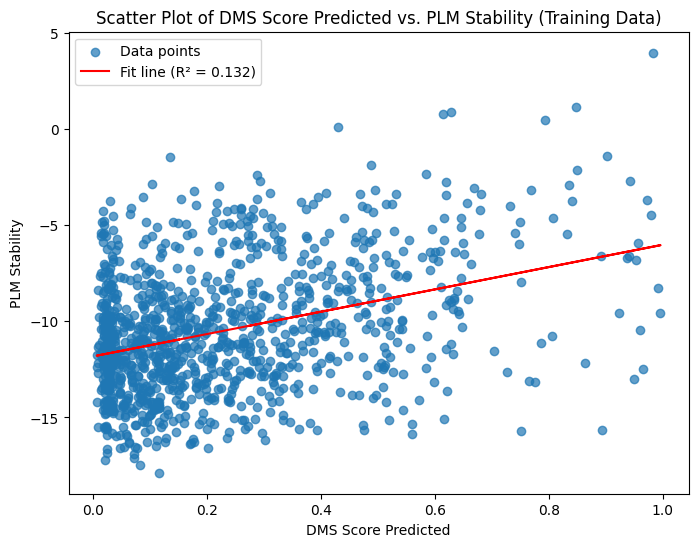

R²: 0.132


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Extract x and y values
x = df_train_labeled["DMS_score"]
y = df_train_labeled["plm_stability"]

# Fit a linear model (y = mx + b)
m, b = np.polyfit(x, y, 1)

# Compute R^2
y_pred = m * x + b
ss_total = np.sum((y - np.mean(y))**2)
ss_residual = np.sum((y - y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7, label="Data points")
plt.plot(x, y_pred, color="red", label=f"Fit line (R² = {r_squared:.3f})")

# Labels and title
plt.xlabel("DMS Score Predicted")
plt.ylabel("PLM Stability")
plt.title("Scatter Plot of DMS Score Predicted vs. PLM Stability (Training Data)")
plt.legend()

# Show the plot
plt.show()

# Print R^2 value
print(f"R²: {r_squared:.3f}")


# LightGBM + Stability Query Predictions

In [2]:
import pandas as pd

df_lightgbm_predictions = pd.read_csv("lightgbm_predictions.csv")
df_stability_predictions = pd.read_parquet("plm_test_embedding.parquet")

In [3]:
df_lightgbm_predictions.head()

,mutant,DMS_score_predicted
0,V1D,0.589655
1,V1Y,0.607739
2,V1C,0.582041
3,V1A,0.634693
4,V1E,0.579828


In [4]:
df_stability_predictions.head()

,mutant,plm_stability
0,V1D,0.352811
1,V1Y,-0.886620
2,V1C,-0.604995
3,V1A,1.840761
4,V1E,1.392013


In [5]:
merged_df = pd.merge(df_lightgbm_predictions, df_stability_predictions, on='mutant', how='outer')  # Use 'outer', 'left', or 'right' as needed
merged_df.head()

,mutant,DMS_score_predicted,plm_stability
0,A115C,0.605174,-7.671821
1,A115D,0.594581,-11.707266
2,A115E,0.590558,-11.642929
3,A115F,0.575555,-13.872354
4,A115G,0.585393,-6.712531


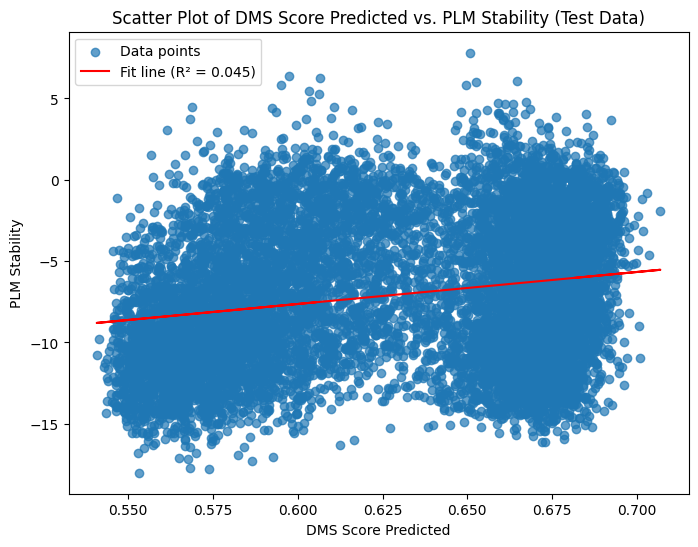

R²: 0.045


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extract x and y values
x = merged_df["DMS_score_predicted"]
y = merged_df["plm_stability"]

# Fit a linear model (y = mx + b)
m, b = np.polyfit(x, y, 1)

# Compute R^2
y_pred = m * x + b
ss_total = np.sum((y - np.mean(y))**2)
ss_residual = np.sum((y - y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7, label="Data points")
plt.plot(x, y_pred, color="red", label=f"Fit line (R² = {r_squared:.3f})")

# Labels and title
plt.xlabel("DMS Score Predicted")
plt.ylabel("PLM Stability")
plt.title("Scatter Plot of DMS Score Predicted vs. PLM Stability (Test Data)")
plt.legend()

# Show the plot
plt.show()

# Print R^2 value
print(f"R²: {r_squared:.3f}")


# Neural Network

1. New amino acid probability ratio
2. structural information
3. esm2 embeddings after

In [17]:
df_train = pd.read_parquet("./protein_embeddings.parquet")
df_q2 = pd.read_parquet("./protein_embeddings_q2.parquet")
df_training = pd.concat([df_train, df_q2], ignore_index=True)
df_training.head()

,mutant,DMS_score,Sequence,Embedding
0,M0Y,0.2730,YVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027215065, -0.07895891, 0.024665577, 0.0871..."
1,M0W,0.2857,WVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027446747, -0.08002905, 0.024973826, 0.0876..."
2,M0V,0.2153,VVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027746126, -0.080583125, 0.024816258, 0.088..."
3,M0T,0.3122,TVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027021304, -0.07973991, 0.024042578, 0.0892..."
4,M0S,0.2180,SVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.02743672, -0.07952291, 0.024383346, 0.09035..."


In [18]:
import pandas as pd
import numpy as np

# --- Define Amino Acid Properties ---
# (Expanded example with more properties)

# Sources for values can include textbooks, review articles, or online databases like AAindex.
# Make sure to note the scale/source if it matters (e.g., different hydrophobicity scales exist).
aa_properties = {
    # AA: {prop1: val1, prop2: val2, ...}
    'A': {'hydro_KD': 1.8,  'volume': 88.6,  'charge': 0, 'polarity': 8.1, 'flexibility': 0.357},
    'R': {'hydro_KD': -4.5, 'volume': 173.4, 'charge': 1, 'polarity': 10.5, 'flexibility': 0.529},
    'N': {'hydro_KD': -3.5, 'volume': 114.1, 'charge': 0, 'polarity': 11.6, 'flexibility': 0.463},
    'D': {'hydro_KD': -3.5, 'volume': 111.1, 'charge': -1, 'polarity': 13.0, 'flexibility': 0.511},
    'C': {'hydro_KD': 2.5,  'volume': 108.5, 'charge': 0, 'polarity': 5.5, 'flexibility': 0.346},
    'Q': {'hydro_KD': -3.5, 'volume': 143.8, 'charge': 0, 'polarity': 10.5, 'flexibility': 0.493},
    'E': {'hydro_KD': -3.5, 'volume': 138.4, 'charge': -1, 'polarity': 12.3, 'flexibility': 0.497},
    'G': {'hydro_KD': -0.4, 'volume': 60.1,  'charge': 0, 'polarity': 9.0, 'flexibility': 0.544},
    'H': {'hydro_KD': -3.2, 'volume': 153.2, 'charge': 0, 'polarity': 10.4, 'flexibility': 0.323}, # Note: Charge is pH dependent; 0 here is simplified neutral form
    'I': {'hydro_KD': 4.5,  'volume': 166.7, 'charge': 0, 'polarity': 5.2, 'flexibility': 0.462},
    'L': {'hydro_KD': 3.8,  'volume': 166.7, 'charge': 0, 'polarity': 4.9, 'flexibility': 0.365},
    'K': {'hydro_KD': -3.9, 'volume': 168.6, 'charge': 1, 'polarity': 11.3, 'flexibility': 0.466},
    'M': {'hydro_KD': 1.9,  'volume': 162.9, 'charge': 0, 'polarity': 5.7, 'flexibility': 0.295},
    'F': {'hydro_KD': 2.8,  'volume': 189.9, 'charge': 0, 'polarity': 5.2, 'flexibility': 0.314},
    'P': {'hydro_KD': -1.6, 'volume': 112.7, 'charge': 0, 'polarity': 8.0, 'flexibility': 0.509}, # Proline is conformationally restricted
    'S': {'hydro_KD': -0.8, 'volume': 89.0,  'charge': 0, 'polarity': 9.2, 'flexibility': 0.507},
    'T': {'hydro_KD': -0.7, 'volume': 116.1, 'charge': 0, 'polarity': 8.6, 'flexibility': 0.444},
    'W': {'hydro_KD': -0.9, 'volume': 227.8, 'charge': 0, 'polarity': 5.4, 'flexibility': 0.305},
    'Y': {'hydro_KD': -1.3, 'volume': 193.6, 'charge': 0, 'polarity': 6.2, 'flexibility': 0.420},
    'V': {'hydro_KD': 4.2,  'volume': 140.0, 'charge': 0, 'polarity': 5.9, 'flexibility': 0.386},
    # Handle non-standard/unknown amino acids if necessary
    'X': {'hydro_KD': np.nan, 'volume': np.nan, 'charge': np.nan, 'polarity': np.nan, 'flexibility': np.nan},
    '-': {'hydro_KD': np.nan, 'volume': np.nan, 'charge': np.nan, 'polarity': np.nan, 'flexibility': np.nan} # Gap character
}

# --- How to use it in your feature engineering function ---
# (Integrating with the previous code example structure)

def calculate_features_with_props(row, properties_dict):
    wt_aa = row['WT_AA']
    mut_aa = row['Mutant_AA']
    features = {}

    # Get properties
    wt_props = properties_dict.get(wt_aa, properties_dict.get('X')) # Default to 'X' if AA not found
    mut_props = properties_dict.get(mut_aa, properties_dict.get('X'))

    # Create features for each property
    for prop_name in wt_props.keys(): # Iterate through property names (hydro_KD, volume, etc.)
        wt_val = wt_props[prop_name]
        mut_val = mut_props.get(prop_name, np.nan) # Get corresponding mutant prop

        features[f'wt_{prop_name}'] = wt_val
        features[f'mut_{prop_name}'] = mut_val

        # Calculate the difference (Delta feature)
        if pd.notna(wt_val) and pd.notna(mut_val):
            features[f'delta_{prop_name}'] = mut_val - wt_val
        else:
            features[f'delta_{prop_name}'] = np.nan

    # ... add other features like position, one-hot encoding, etc. ...
    features['position'] = row['Position']

    return pd.Series(features)

# --- Example Usage with your DataFrame 'df' ---
# Assuming df has 'WT_AA' and 'Mutant_AA' columns

# df = pd.read_csv('../train.csv')

def add_physical(df):
    df['WT_AA'] = df["mutant"].apply(lambda seq: seq[0])
    df['Mutant_AA'] = df["mutant"].apply(lambda seq: seq[-1])
    df['Position'] = df["mutant"].apply(lambda seq: int(seq[1:-1]))

    feature_df = df.apply(lambda row: calculate_features_with_props(row, aa_properties), axis=1)
    return feature_df

# # ... proceed with combining features, handling NaNs, splitting data, training ...
# print(feature_df.head())

In [19]:
# 2. physical features added
feature_df = add_physical(df_training)
df_training = pd.concat((df_training, feature_df),axis=1)
df_training.head()

,mutant,DMS_score,Sequence,Embedding,WT_AA,Mutant_AA,Position,wt_hydro_KD,mut_hydro_KD,delta_hydro_KD,...,wt_charge,mut_charge,delta_charge,wt_polarity,mut_polarity,delta_polarity,wt_flexibility,mut_flexibility,delta_flexibility,position
0,M0Y,0.2730,YVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027215065, -0.07895891, 0.024665577, 0.0871...",M,Y,0,1.9,-1.3,-3.2,...,0.0,0.0,0.0,5.7,6.2,0.5,0.295,0.420,0.125,0.0
1,M0W,0.2857,WVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027446747, -0.08002905, 0.024973826, 0.0876...",M,W,0,1.9,-0.9,-2.8,...,0.0,0.0,0.0,5.7,5.4,-0.3,0.295,0.305,0.010,0.0
2,M0V,0.2153,VVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027746126, -0.080583125, 0.024816258, 0.088...",M,V,0,1.9,4.2,2.3,...,0.0,0.0,0.0,5.7,5.9,0.2,0.295,0.386,0.091,0.0
3,M0T,0.3122,TVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027021304, -0.07973991, 0.024042578, 0.0892...",M,T,0,1.9,-0.7,-2.6,...,0.0,0.0,0.0,5.7,8.6,2.9,0.295,0.444,0.149,0.0
4,M0S,0.2180,SVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.02743672, -0.07952291, 0.024383346, 0.09035...",M,S,0,1.9,-0.8,-2.7,...,0.0,0.0,0.0,5.7,9.2,3.5,0.295,0.507,0.212,0.0


In [20]:
# 3. plm stability
heatmap = np.load("sequence_mutation_heatmap.npy")

def lookup_mutation(mutation_str):
    new_aa = mutation_str[-1]
    position = int(mutation_str[1:-1])

    new_aa_index = AMINO_ACIDS.index(new_aa)

    return heatmap[new_aa_index, position]

df_training["plm_stability"] = df_training["mutant"].apply(lambda x: lookup_mutation(x))
df_training.head()


,mutant,DMS_score,Sequence,Embedding,WT_AA,Mutant_AA,Position,wt_hydro_KD,mut_hydro_KD,delta_hydro_KD,...,mut_charge,delta_charge,wt_polarity,mut_polarity,delta_polarity,wt_flexibility,mut_flexibility,delta_flexibility,position,plm_stability
0,M0Y,0.2730,YVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027215065, -0.07895891, 0.024665577, 0.0871...",M,Y,0,1.9,-1.3,-3.2,...,0.0,0.0,5.7,6.2,0.5,0.295,0.420,0.125,0.0,-5.810225
1,M0W,0.2857,WVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027446747, -0.08002905, 0.024973826, 0.0876...",M,W,0,1.9,-0.9,-2.8,...,0.0,0.0,5.7,5.4,-0.3,0.295,0.305,0.010,0.0,-6.154084
2,M0V,0.2153,VVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027746126, -0.080583125, 0.024816258, 0.088...",M,V,0,1.9,4.2,2.3,...,0.0,0.0,5.7,5.9,0.2,0.295,0.386,0.091,0.0,-4.331811
3,M0T,0.3122,TVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027021304, -0.07973991, 0.024042578, 0.0892...",M,T,0,1.9,-0.7,-2.6,...,0.0,0.0,5.7,8.6,2.9,0.295,0.444,0.149,0.0,-4.608084
4,M0S,0.2180,SVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.02743672, -0.07952291, 0.024383346, 0.09035...",M,S,0,1.9,-0.8,-2.7,...,0.0,0.0,5.7,9.2,3.5,0.295,0.507,0.212,0.0,-3.859121


In [21]:
df_training["WT_AA_"] = df_training["WT_AA"].map(lambda x: AMINO_ACIDS.index(x))
df_training["Mutant_AA_"] = df_training["Mutant_AA"].map(lambda x: AMINO_ACIDS.index(x))

In [22]:
# Assuming df is your DataFrame
feature_columns = [
    "WT_AA_", "Mutant_AA_", "Position", "wt_hydro_KD", "mut_hydro_KD", "delta_hydro_KD",
    "mut_charge", "delta_charge", "wt_polarity", "mut_polarity", "delta_polarity",
    "wt_flexibility", "mut_flexibility", "delta_flexibility", "position", "plm_stability"
]

# Extract numeric features
X_numeric = df_training[feature_columns].to_numpy()

# Flatten embeddings from string representation to numerical lists
X_embedding = np.stack(df_training["Embedding"])

# Concatenate embedding and other features
X = np.hstack([X_embedding, X_numeric])
y = df_training["DMS_score"]
X.shape, y.shape

((2580, 1296), (2580,))

In [23]:
X.astype(np.float32)

array([[ 2.7215065e-02, -7.8958914e-02,  2.4665577e-02, ...,
         1.2500000e-01,  0.0000000e+00, -5.8102255e+00],
       [ 2.7446747e-02, -8.0029048e-02,  2.4973826e-02, ...,
         9.9999998e-03,  0.0000000e+00, -6.1540842e+00],
       [ 2.7746126e-02, -8.0583125e-02,  2.4816258e-02, ...,
         9.0999998e-02,  0.0000000e+00, -4.3318110e+00],
       ...,
       [ 2.7312450e-02, -7.9918429e-02,  2.5480052e-02, ...,
        -9.7000003e-02,  6.0800000e+02,  4.5890045e-01],
       [ 2.7512638e-02, -8.0506608e-02,  2.4545368e-02, ...,
        -1.0600000e-01,  6.1000000e+02, -1.9380779e+00],
       [ 2.6863875e-02, -7.5674541e-02,  2.5063604e-02, ...,
         1.8799999e-01,  6.1200000e+02, -8.2116470e+00]], dtype=float32)

In [24]:
y_train.shape, y_test.shape

NameError: name 'y_train' is not defined

In [25]:
from sklearn.model_selection import train_test_split
import torch
device = "cuda"
from torch.utils.data import DataLoader, TensorDataset, random_split

X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)  # Reshape to (N, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
device = "cuda"

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import spearmanr

# Define a more robust MLP regression model
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),  # Normalization to stabilize training
            nn.ReLU(),
            nn.Dropout(0.2),  # Prevent overfitting
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Custom Spearman-friendly loss function
def spearman_loss(y_pred, y_true):
    return -torch.cosine_similarity(y_pred.view(1, -1), y_true.view(1, -1))

# Initialize model, loss function, and optimizer
model = MLPRegressor(input_dim=X.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-5)  # Weight decay added
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop
epochs = 40000
best_val_loss = float('inf')
patience, patience_counter = 5000, 0  # Early stopping

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = spearman_loss(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Learning rate scheduling
    scheduler.step(loss)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Early stopping
    if loss.item() < best_val_loss:
        best_val_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluate on test set
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        loss = spearman_loss(predictions, batch_y)
        test_loss += loss.item()
print(f"Test Spearman Loss: {test_loss.item():.4f}")

# Compute Spearman correlation
spearman_corr, _ = spearmanr(y_test.cpu().numpy().flatten(), test_predictions.cpu().numpy().flatten())
print(f"MLP Spearman Correlation: {spearman_corr:.4f}")

/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 

In [29]:
model = MLPRegressor(input_dim=X.shape[1]).to(device)
print(model)


MLPRegressor(
  (model): Sequential(
    (0): Linear(in_features=1296, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=64, bias=True)
    (12): ReLU()
    (13): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [77]:

# Evaluate on test set
model.eval()
test_loss = 0
test_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        test_predictions.extend(predictions.cpu())
        loss = spearman_loss(predictions, batch_y)
        test_loss += loss.item()
print(f"Test Spearman Loss: {test_loss:.4f}")

# # Compute Spearman correlation
spearman_corr, _ = spearmanr(y_test, test_predictions)
print(f"MLP Spearman Correlation: {spearman_corr:.4f}")

Test Spearman Loss: -7.8507
MLP Spearman Correlation: 0.6622


In [78]:
torch.save(model.state_dict(), "model.pth")


# Test Eval

In [93]:
df_unlabeled = pd.read_parquet("protein_embeddings_test.parquet")
df_unlabeled.tail()
print(df_unlabeled.shape)

(11324, 3)


In [94]:
feature_df = add_physical(df_unlabeled)
df_unlabeled = pd.concat((df_unlabeled, feature_df),axis=1)
df_unlabeled.tail()
print(df_unlabeled.shape)

(11324, 22)


In [95]:
df_unlabeled.tail()

,mutant,Sequence,Embedding,WT_AA,Mutant_AA,Position,wt_hydro_KD,mut_hydro_KD,delta_hydro_KD,wt_volume,...,wt_charge,mut_charge,delta_charge,wt_polarity,mut_polarity,delta_polarity,wt_flexibility,mut_flexibility,delta_flexibility,position
11319,P655S,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027154014, -0.07823243, 0.025655007, 0.0870...",P,S,655,-1.6,-0.8,0.8,112.7,...,0.0,0.0,0.0,8.0,9.2,1.2,0.509,0.507,-0.002,655.0
11320,P655T,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027135067, -0.07772149, 0.025120975, 0.0859...",P,T,655,-1.6,-0.7,0.9,112.7,...,0.0,0.0,0.0,8.0,8.6,0.6,0.509,0.444,-0.065,655.0
11321,P655V,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.026493885, -0.077684514, 0.025547283, 0.086...",P,V,655,-1.6,4.2,5.8,112.7,...,0.0,0.0,0.0,8.0,5.9,-2.1,0.509,0.386,-0.123,655.0
11322,P655A,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.025742685, -0.07662509, 0.02524467, 0.08547...",P,A,655,-1.6,1.8,3.4,112.7,...,0.0,0.0,0.0,8.0,8.1,0.1,0.509,0.357,-0.152,655.0
11323,P655W,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027710976, -0.0777725, 0.02584177, 0.086656...",P,W,655,-1.6,-0.9,0.7,112.7,...,0.0,0.0,0.0,8.0,5.4,-2.6,0.509,0.305,-0.204,655.0


In [96]:
df_unlabeled["plm_stability"] = df_unlabeled["mutant"].apply(lambda x: lookup_mutation(x))
heatmap = np.load("sequence_mutation_heatmap.npy")

def lookup_mutation(mutation_str):
    new_aa = mutation_str[-1]
    position = int(mutation_str[1:-1])

    new_aa_index = AMINO_ACIDS.index(new_aa)

    return heatmap[new_aa_index, position]
df_unlabeled.head()

,mutant,Sequence,Embedding,WT_AA,Mutant_AA,Position,wt_hydro_KD,mut_hydro_KD,delta_hydro_KD,wt_volume,...,mut_charge,delta_charge,wt_polarity,mut_polarity,delta_polarity,wt_flexibility,mut_flexibility,delta_flexibility,position,plm_stability
0,V1D,MDNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.026937608, -0.07856282, 0.024653217, 0.0871...",V,D,1,4.2,-3.5,-7.7,140.0,...,-1.0,-1.0,5.9,13.0,7.1,0.386,0.511,0.125,1.0,0.352811
1,V1Y,MYNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.02749172, -0.07658019, 0.02500999, 0.087213...",V,Y,1,4.2,-1.3,-5.5,140.0,...,0.0,0.0,5.9,6.2,0.3,0.386,0.420,0.034,1.0,-0.886620
2,V1C,MCNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.02720123, -0.07751231, 0.025550483, 0.08742...",V,C,1,4.2,2.5,-1.7,140.0,...,0.0,0.0,5.9,5.5,-0.4,0.386,0.346,-0.040,1.0,-0.604995
3,V1A,MANEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.025444617, -0.07854507, 0.023187876, 0.0863...",V,A,1,4.2,1.8,-2.4,140.0,...,0.0,0.0,5.9,8.1,2.2,0.386,0.357,-0.029,1.0,1.840761
4,V1E,MENEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.026875637, -0.07995216, 0.02439556, 0.08796...",V,E,1,4.2,-3.5,-7.7,140.0,...,-1.0,-1.0,5.9,12.3,6.4,0.386,0.497,0.111,1.0,1.392013


In [106]:
df_unlabeled["WT_AA_"] = df_unlabeled["WT_AA"].map(lambda x: AMINO_ACIDS.index(x))
df_unlabeled["Mutant_AA_"] = df_unlabeled["Mutant_AA"].map(lambda x: AMINO_ACIDS.index(x))

In [107]:
# Assuming df is your DataFrame
feature_columns = [
    "WT_AA_", "Mutant_AA_", "Position", "wt_hydro_KD", "mut_hydro_KD", "delta_hydro_KD",
    "mut_charge", "delta_charge", "wt_polarity", "mut_polarity", "delta_polarity",
    "wt_flexibility", "mut_flexibility", "delta_flexibility", "position", "plm_stability"
]

# Extract numeric features
X_numeric = df_unlabeled[feature_columns].to_numpy()

# Flatten embeddings from string representation to numerical lists
X_embedding = np.stack(df_unlabeled["Embedding"])

# Concatenate embedding and other features
X = np.hstack([X_embedding, X_numeric])
X = X.astype(np.float32)
X.shape, y.shape

((11324, 1296), (2580,))

In [121]:
model.eval()
x = torch.tensor(X, device=device)
predictions = model(x).detach().cpu().numpy().squeeze(-1)
predictions.shape

(11324,)

In [122]:
df_lightgbm = pd.read_csv("lightgbm_predictions.csv")
y = df_lightgbm["DMS_score_predicted"]


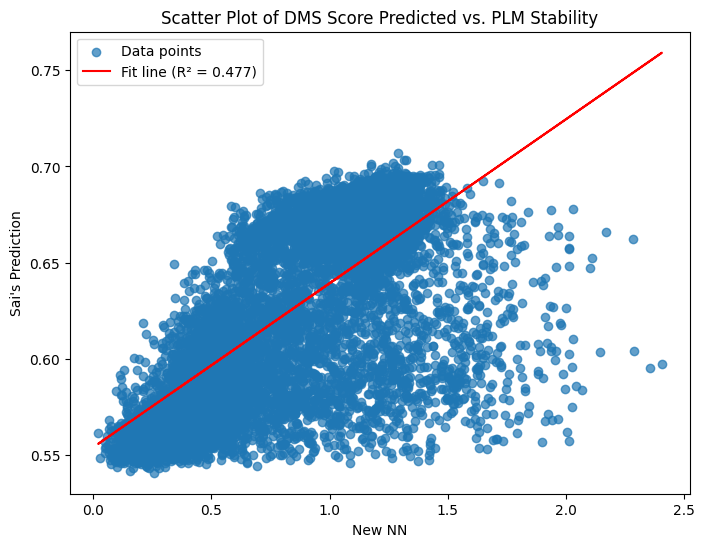

R²: 0.477


In [123]:
import matplotlib.pyplot as plt
import numpy as np

# Fit a linear model (y = mx + b)
m, b = np.polyfit(predictions, y, 1)

# Compute R^2
y_pred = m * predictions + b
ss_total = np.sum((y - np.mean(y))**2)
ss_residual = np.sum((y - y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(predictions, y, alpha=0.7, label="Data points")
plt.plot(predictions, y_pred, color="red", label=f"Fit line (R² = {r_squared:.3f})")

# Labels and title
plt.xlabel("New NN")
plt.ylabel("Sai's Prediction")
plt.title("Scatter Plot of DMS Score Predicted vs. PLM Stability")
plt.legend()

# Show the plot
plt.show()

# Print R^2 value
print(f"R²: {r_squared:.3f}")


# Query 3

In [124]:
neural_network_fitness = predictions
lightgbm_dms = y 

In [127]:
queried = []

df_q1 = pd.read_csv("../query1.csv")
df_q2 = pd.read_csv("../query2.csv")

queried = df_q1['mutant'].to_list()  + df_q2['mutant'].to_list() 
len(queried)

200

In [156]:
composite = np.array(neural_network_fitness) * np.array(lightgbm_dms)
df_lightgbm["composite_score"] = composite
# Get indices of top 200 values
top200_indices = composite.argsort()[-200:]
df_to_query = df_lightgbm.iloc[top200_indices]

In [157]:
mask = df_to_query["mutant"].isin(queried)  # Create boolean mask
df_filtered = df_to_query.loc[~mask]  # Keep only rows where mutant is NOT in queried

print(df_filtered)


     mutant  DMS_score_predicted  composite_score
4125  D244A             0.610591         1.004205
6741  E414A             0.685181         1.004587
8141  N488W             0.675758         1.004751
3473  E202D             0.633168         1.005342
700    D37F             0.628528         1.005479
...     ...                  ...              ...
2400  R133P             0.603880         1.382121
2402  R133T             0.594996         1.402190
2398  R133S             0.597325         1.437567
2466  E136V             0.665995         1.445042
3903  E231K             0.662105         1.512260

[186 rows x 3 columns]


In [169]:
df_filtered = df_filtered.sort_values(by="composite_score")
query3_composite = df_filtered.mutant.to_list()[-100:]

In [162]:
with open("query3.txt", "w") as f:
    out = "\n".join(query3)
    f.write(out)

In [181]:
df_filtered = df_filtered.sort_values(by="DMS_score_predicted")
query3_sai = df_filtered.mutant.to_list()[-100:]
df_filtered.shape

(186, 3)

In [175]:
common_mutations = set(query3_sai) & set(query3_composite)
common_mutations = list(common_mutations)

In [178]:
df_filtered.mutant.isin(common_mutations).sum()

56

In [184]:
df_ex_composite = df_filtered.loc[~df_filtered.mutant.isin(common_mutations), :]
df_ex_composite = df_ex_composite.sort_values(by="composite_score")
df_ex_composite

,mutant,DMS_score_predicted,composite_score
4125,D244A,0.610591,1.004205
6741,E414A,0.685181,1.004587
8141,N488W,0.675758,1.004751
3473,E202D,0.633168,1.005342
700,D37F,0.628528,1.005479
...,...,...,...
1292,E70S,0.626262,1.253505
4006,F236L,0.603341,1.294753
2400,R133P,0.603880,1.382121
2402,R133T,0.594996,1.402190


In [186]:
ex_mutations = df_ex_composite.mutant.to_list()[-22:]

In [187]:
df_ex_lightgbm = df_filtered.loc[~df_filtered.mutant.isin(common_mutations), :]
df_ex_lightgbm = df_ex_lightgbm.sort_values(by="DMS_score_predicted")
df_ex_lightgbm

,mutant,DMS_score_predicted,composite_score
3500,G204S,0.556778,1.058509
3514,G204L,0.557317,1.121445
3512,G204D,0.561489,1.007315
3497,G204V,0.561883,1.127513
2843,D162G,0.567688,1.084639
...,...,...,...
9746,T572Y,0.686737,1.047039
7772,E469A,0.687406,1.008114
10240,Y598V,0.687938,1.014437
9698,Q570W,0.689298,1.028132


In [188]:
ex_light_mutations = df_ex_lightgbm.mutant.to_list()[-22:]

In [191]:
query3 = set(ex_light_mutations) | (set(ex_mutations)) | set(common_mutations)
len(query3)

100

In [192]:
with open("query3.txt", "w") as f:
    out = "\n".join(query3)
    f.write(out)

In [194]:
set(query3) & set(queried)

set()

# NN Predictions - Safety

In [168]:
df_test_output = pd.read_csv("../test.csv")
df_test_output["DMS_score_predicted"] = predictions
df_test_output.to_csv("nn_predictions.csv", index=False)

In [163]:
len(predictions)

11324

# Top 10 Predictions

In [1]:
import numpy as nn_predictions
import pandas as pd

In [2]:
df_predictions = pd.read_csv("../predictions.csv")

In [9]:
df_predictions = df_predictions.sort_values(by="DMS_score_predicted")
top10 = df_predictions.tail(10).mutant.to_list()
top10

['E600Q',
 'F236L',
 'H538Q',
 'E15K',
 'W582V',
 'E415Q',
 'T572Y',
 'E415L',
 'E70A',
 'E415V']

In [8]:
with open("top10.txt", "w") as f:
    out = "\n".join(top10)
    f.write(out)

# Only from Query

In [34]:
queried = []

df_train = pd.read_csv("../train.csv")
df_q1 = pd.read_csv("../query1.csv")
df_q2 = pd.read_csv("../query2.csv")
df_q3 = pd.read_csv("../query3.csv")


df_ground = pd.concat([df_train, df_q1, df_q2, df_q3], axis=0)
len(df_ground)

1440

In [35]:
df_ground = df_ground.sort_values(by="DMS_score")
df_ground.tail(10)

,mutant,DMS_score,sequence
73,F236L,0.981089,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
67,H538Q,0.983055,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
9,E15K,0.983077,MVNEARGNSSLNPCLKGSASSGSESSKDSSRCSTPGLDPERHERLR...
85,W582V,0.983191,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
90,Y89F,0.983300,NaN
94,T572Y,0.984871,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
13,E70A,0.989501,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
657,I258L,0.990900,NaN
61,E415V,0.991410,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
661,I258F,0.995700,NaN


In [36]:
top10 = df_ground.tail(10).mutant.to_list()

with open("top10.txt", "w") as f:
    out = "\n".join(top10)
    f.write(out)

In [37]:
import numpy as np

AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")
heatmap = np.load("sequence_mutation_heatmap.npy")

def lookup_mutation(mutation_str):
    new_aa = mutation_str[-1]
    position = int(mutation_str[1:-1])

    new_aa_index = AMINO_ACIDS.index(new_aa)

    return heatmap[new_aa_index, position]

df_ground["plm_stability"] = df_ground["mutant"].apply(lambda x: lookup_mutation(x))

df_ground.tail(10)

,mutant,DMS_score,sequence,plm_stability
73,F236L,0.981089,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,5.470484
67,H538Q,0.983055,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,-4.391042
9,E15K,0.983077,MVNEARGNSSLNPCLKGSASSGSESSKDSSRCSTPGLDPERHERLR...,-0.760066
85,W582V,0.983191,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,-12.589500
90,Y89F,0.983300,NaN,3.961531
94,T572Y,0.984871,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,-13.053039
13,E70A,0.989501,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,2.104316
657,I258L,0.990900,NaN,-8.253258
61,E415V,0.991410,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,-3.177378
661,I258F,0.995700,NaN,-9.556507


In [38]:
plm_norm = (df_ground["plm_stability"] - df_ground["plm_stability"].min()) / (df_ground['plm_stability'].max() - df_ground['plm_stability'].min())
df_ground["composite"] = plm_norm * df_ground["DMS_score"]
df_ground = df_ground.sort_values(by="composite")
df_ground.tail(10)

,mutant,DMS_score,sequence,plm_stability,composite
45,M153L,0.916393,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,2.726863,0.779268
22,R131N,0.879593,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,3.738044,0.784692
26,R133P,0.848073,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,4.822561,0.794542
72,F236I,0.918576,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,3.165456,0.797756
48,E358V,0.899604,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,3.647572,0.799184
13,E70A,0.989501,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,2.104316,0.816007
45,K490A,0.969593,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,2.759111,0.825798
18,E70Q,0.947935,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,3.532375,0.837612
90,Y89F,0.983300,NaN,3.961531,0.886282
73,F236L,0.981089,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,5.470484,0.945404


In [39]:
top10_composite = df_ground["mutant"].to_list()
common = set(top10) & set(top10_composite)
len(common)

10

In [41]:
common

{'E15K',
 'E415V',
 'E70A',
 'F236L',
 'H538Q',
 'I258F',
 'I258L',
 'T572Y',
 'W582V',
 'Y89F'}